# Классификатор каегорий товаров

## Библиотеки

In [ ]:
!pip install transformers
from transformers import BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.4 MB/s eta 0:00:00


In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
# import tensorflow as tf
# import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input
from keras.optimizers import Adam
from keras.utils import to_categorical

# from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, Reshape
from tensorflow.keras.layers import Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score as f1
from PIL import Image

## Обработка файлов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/dataset.zip' -d '/content'

In [ ]:
df = pd.read_parquet('/content/train.parquet')

In [ ]:
df['description'] = df.text_fields.apply(lambda x: json.loads(x)['description'])
df['description'] = df['description'].apply(lambda x: re.sub(r'<.*?>', '', x))

category_unique = df['category_id'].unique()
category_count = len(category_unique)
classes = np.arange(category_count)

category2class = {x: i for i, x in enumerate(category_unique)}
class2category = {i: x for i, x in enumerate(category_unique)}
df['classes'] = df['category_id'].map(category2class)

## Обработка описаний товаров

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

maxlen = len(df['description'].max())
texts = []
for text in df['description']:
    token = tokenizer.encode(text, max_length=512, truncation=True, return_tensors='tf')[0]
    token = list(np.array(token)) + [0] * (maxlen - len(token))  
    texts.append(token)

texts = np.asarray(texts)

labels = to_categorical(list(df['classes']), category_count)

x_train, x_valid = texts[:70000], texts[70000:]
y_train, y_valid = labels[:70000], labels[70000:]

print(x_train.shape, x_valid.shape)
print(y_train.shape, y_valid.shape)

(70000, 662) (21120, 662)
(70000, 874) (21120, 874)


## Обработка изображений

In [ ]:
# Сжимаю изображения 512*512 до 16*16, нормализую, выпрямляю и сохраняю в список
files_names = df['product_id'].values
image_list = []
for i, name in enumerate(files_names):
    print(i, end='')
    image_name = '/content/images/train/' + str(name) + '.jpg'
    image = Image.open(image_name)
    image.thumbnail((16, 16), reducing_gap=None)
    image_array = np.array(image) / 255.0
    image_array = image_array.flatten()
    image_list.append(image_array)
    print('\r', end='')


In [ ]:
img_train, img_valid = np.asarray(image_list[:70_000]), np.asarray(image_list[70_000:])

## Обучение модели

In [ ]:
# Модель на два входа input_description и input_image

input_description = Input(x_train.shape[1],)
id = Embedding(tokenizer.vocab_size, 8)(input_description)
id = SpatialDropout1D(0.2)(id)
id = Flatten()(id)
id = BatchNormalization()(id)
id = Dense(category_count, activation='relu')(id)
id = Dropout(0.2)(id)
id = BatchNormalization()(id)

input_image = Input(len(image_list[0]),)
ii = Reshape((16, 16, 3))(input_image)
ii = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(ii)
ii = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(ii)
ii = MaxPooling2D(pool_size=(2, 2))(ii) # (16, 16)
ii = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(ii)
ii = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(ii)
ii = MaxPooling2D(pool_size=(2, 2))(ii) # (8, 8)
ii = Flatten()(ii)
ii = Dense(category_count, activation='relu')(ii)
ii = BatchNormalization()(ii)

out = concatenate([id, ii])

output = Dense(category_count, activation='softmax')(out)

model = Model([input_description, input_image], output)

In [ ]:
# Метрика f1-score

from keras.utils import custom_object_scope
from tensorflow.keras import backend as K

with custom_object_scope({'f1_score': f1_score}): 

    def f1_score(y_true, y_pred):

        c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
        c2 = K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon()
        c3 = K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon()

        if c3 == 0:
            return 0.0

        precision = c1 / c2

        recall = c1 / c3

        f1_score = 2 * (precision * recall) / (precision + recall)

        return f1_score

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=[f1_score])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 16, 16, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 8)    224         ['reshape_1[0][0]']              
                                                                                                  
 input_3 (InputLayer)           [(None, 662)]        0           []                               
                                                                                            

In [ ]:
history = model.fit([x_train, img_train], y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=([x_valid, img_valid], y_valid),
                    verbose=1,
                    shuffle=False)

Epoch 1/10
2188/2188 [==============================] - 22s 9ms/step - loss: 4.1245 - f1_score: 0.3074 - val_loss: 3.4645 - val_f1_score: 0.4324
Epoch 2/10
2188/2188 [==============================] - 20s 9ms/step - loss: 2.0690 - f1_score: 0.5697 - val_loss: 3.3063 - val_f1_score: 0.4864
Epoch 3/10
2188/2188 [==============================] - 21s 10ms/step - loss: 1.2494 - f1_score: 0.7270 - val_loss: 3.7153 - val_f1_score: 0.4800
Epoch 4/10
2188/2188 [==============================] - 21s 10ms/step - loss: 0.9712 - f1_score: 0.7792 - val_loss: 3.9611 - val_f1_score: 0.4836
Epoch 5/10
2188/2188 [==============================] - 21s 10ms/step - loss: 0.8005 - f1_score: 0.8133 - val_loss: 4.4384 - val_f1_score: 0.4645
Epoch 6/10
2188/2188 [==============================] - 21s 10ms/step - loss: 0.6926 - f1_score: 0.8352 - val_loss: 4.5961 - val_f1_score: 0.4654
Epoch 7/10
2188/2188 [==============================] - 21s 10ms/step - loss: 0.6130 - f1_score: 0.8505 - val_loss: 4.4334 - v

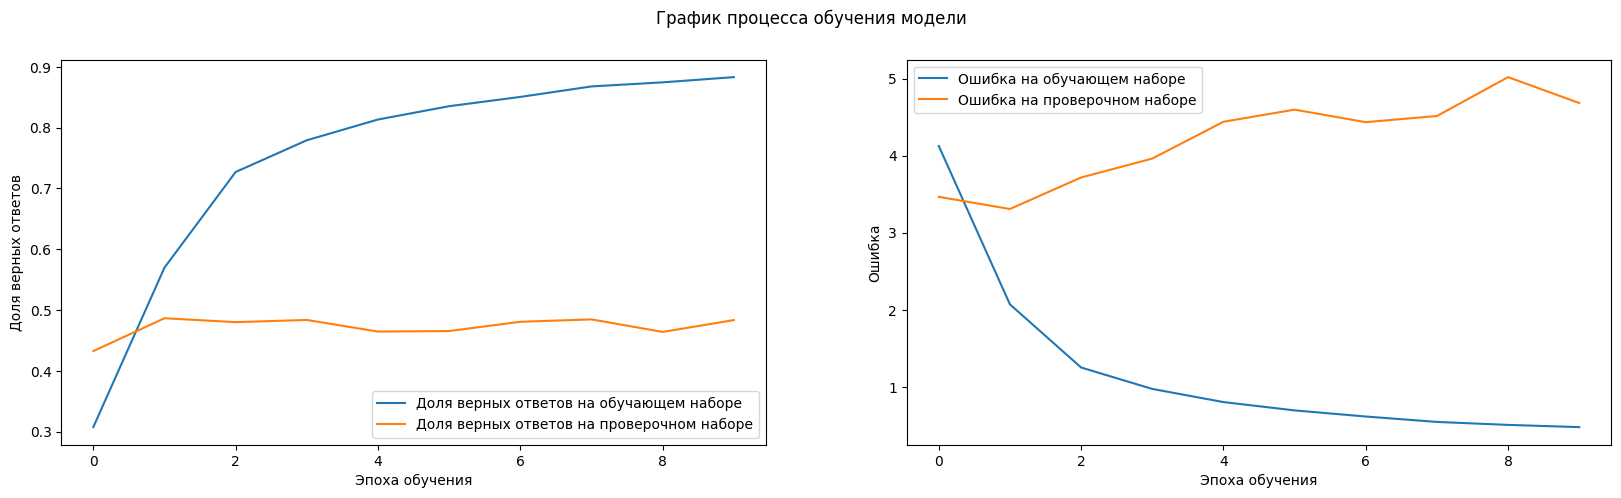

In [ ]:
# Вывод графиков f1_score и loss

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['f1_score'], 
          label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_f1_score'], 
          label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'], 
          label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'], 
          label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

## Тестирование модели

In [ ]:
y_pred = model.predict([x_valid, img_valid])
y_pred_class = np.argmax(y_pred, axis=1)  # преобразуем предсказания из one-hot encoding в классы
y_test_class = np.argmax(y_valid, axis=1)  # преобразуем предсказания из one-hot encoding в классы
f1score = f1(y_test_class, y_pred_class, average='weighted')
print('F1 score: {}'.format(f1score))

660/660 [==============================] - 2s 3ms/step
F1 score: 0.42698104257316033
